# Exploration of airlines delays  
## by Mathieu Le Cam

## Investigation Overview

This presentation reports on the investigation of the airlines delays in the US from 2004 to 2020. The U.S. Department of Transportation's Bureau of Transportation Statistics provided the dataset, which tracks the on-time performance of domestic flights operated by large air carriers. The main features of interest in this study is the cumulated delay in arrival of airlines. Since a flight is considered delayed when it arrived 15 or more minutes than the schedule, the number of flights delayed is also of importance and the derived percentage of flights delayed.

## Dataset Overview

The dataset gives information on domestic flights in the US, including 28 airlines, arrival and departure delays, and reasons for delays, from 2004 to 2020. The dataset is composed of 271476 rows and 28 columns after wrangling the data. In this dataset, the delays are monthly aggregated per airport and per carrier.

In [5]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df=pd.read_csv('airline_delay_causes.csv')
df=df.drop(columns=['Unnamed: 21'])
df.columns=[col.replace(' ','') for col in df.columns]
df=df.dropna()
df=df.sort_values(by=['year','month'])
df['arr_del_pct']=100*df['arr_del15']/df['arr_flights']
for col in ['carrier', 'weather', 'nas','security','late_aircraft']:
    df[col+'_pct']=100*df[col+'_ct']/df['arr_flights']
df['arr_delay_flight']=df['arr_delay']/df['arr_flights']

## Univariate distribution of the percentage of flights delayed

The graph below presents the univariate distribution of the percentage of flights delayed monthly.
Considering all airports and all airline companies over the whole time period from January 2004 to April 2020, about 20% of the flights are delayed (15 min or more) per month. 90% of the times, for an airline in a given airport, 5 to 40% of the flights are delayed per month. Notice that some airline in some airport presented 100% of the flights delayed during a month.

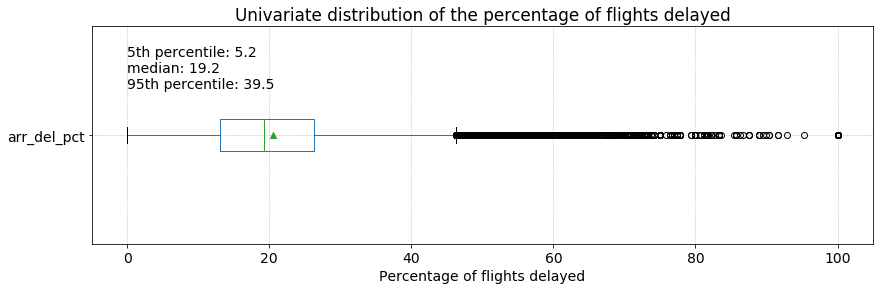

In [9]:
plt.figure(figsize=(14,4))
df.loc[:,['arr_del_pct']].boxplot(vert=False,showmeans=True)
plt.grid(linestyle=':')
perc=[round(i,1) for i in np.percentile(df.loc[:,['arr_del_pct']],[5,50,95])]
plt.text(0,1.2,'5th percentile: {}\nmedian: {}\n95th percentile: {}'.format(perc[0],perc[1],perc[2]),verticalalignment='bottom')
plt.title('Univariate distribution of the percentage of flights delayed')
plt.xlabel('Percentage of flights delayed')
plt.show()

## Bivariate distribution of the percentage of flights delayed per year

The graph below presents the bivariate distribution of the percentage of flights delayed per year, for all airlines and all airports.
We can see again on the first plot on the left that overall 20% of the flights are delayed from 2010 to 2019. In 2020, only four months of data is available and the percentage of flights delayed is smaller (around 12%). From 2000 to 2009, the percentage of flights delayed was higher (22 to 25%). We can observe an improvement through time.

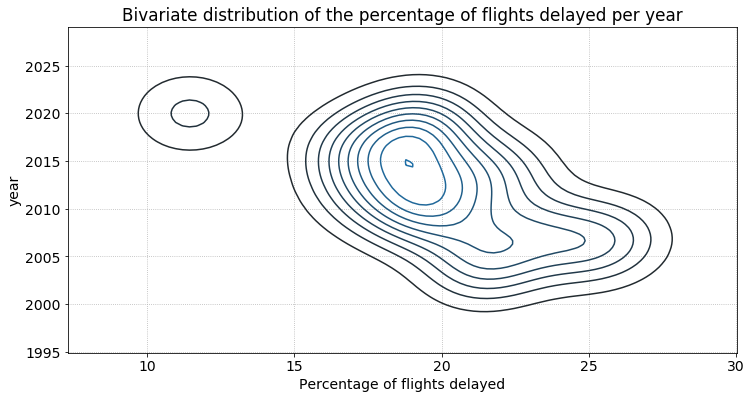

In [19]:
fig, (ax1) = plt.subplots(1,1, figsize=(12,6))
sns.kdeplot(df.groupby('year')['arr_del_pct'].mean(),df.groupby('year')['arr_del_pct'].mean().index,ax=ax1)
ax1.grid(linestyle=':')
ax1.set_title('Bivariate distribution of the percentage of flights delayed per year')
ax1.set_xlabel('Percentage of flights delayed')
plt.show()

## Bivariate distribution of the percentage of flights delayed per airline

The graph below presents the bivariate distribution of the yearly average of the percentage of flights delayed per airline, for all airports from 2004 to 2020.
This plot gives an idea of the variability in flights delayed from one airline company to another. For instance, "UA" airline presents a low percentage of flights delayed (12% in average) and through the whole period from 2004 to 2020; while "AA" airline presents the maximum percentage of about 33% over the whole time period.

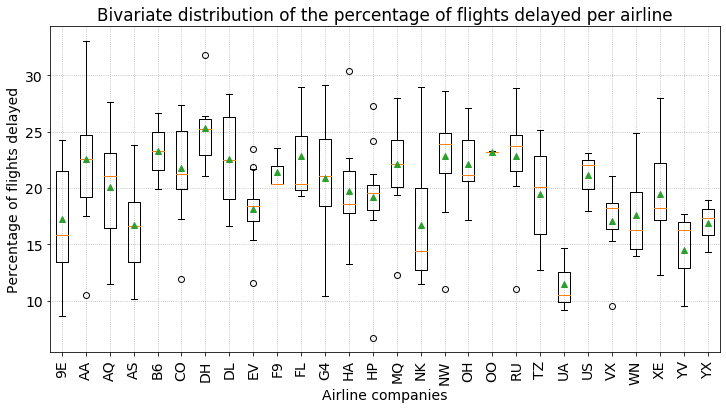

In [20]:
fig, (ax1) = plt.subplots(1,1, figsize=(12,6))
ax1.boxplot([df.loc[df.carrier==arl].groupby('year').mean()['arr_del_pct'] for arl in df.carrier.unique()],showmeans=True)
plt.xticks(range(1,1+len(df.carrier.unique())),df.groupby('carrier')['arr_del_pct'].mean().index, rotation='vertical')
ax1.set_ylabel('Percentage of flights delayed')
ax1.set_xlabel('Airline companies')
ax1.set_title('Bivariate distribution of the percentage of flights delayed per airline')
ax1.grid(linestyle=':')
plt.show()

## Percentage of flights delayed and cumulated delay monthly

The scatter plot below presents the percentage of flights delayed and the monthly cumulated delay, in minutes, averaged per year. The delays are presented for few airlines, differentiated by colours, through the years from 2004 to 2020. The cumulated delay is presented by the position on the y-axis through the years on the x-axis. The percentage of flights delayed is represented by the marker size for each year of each airline. Only 8 out of 28 airline companies are presented on the plot to avoid too much overlapping and improve the visibility.

We can observe the trend noticed previously showing a reduction of the percentage of flights delayed from 2004 to 2020. This trend can be observed for most of the airlines, an additional information that could not be seen earlier. This means that some improvements have been made in the technologies and/or processes used by the airlines. Also we can see that, in general, the airlines showing higher percentage of flights delayed also have higher cumulated delay; this could be expected.

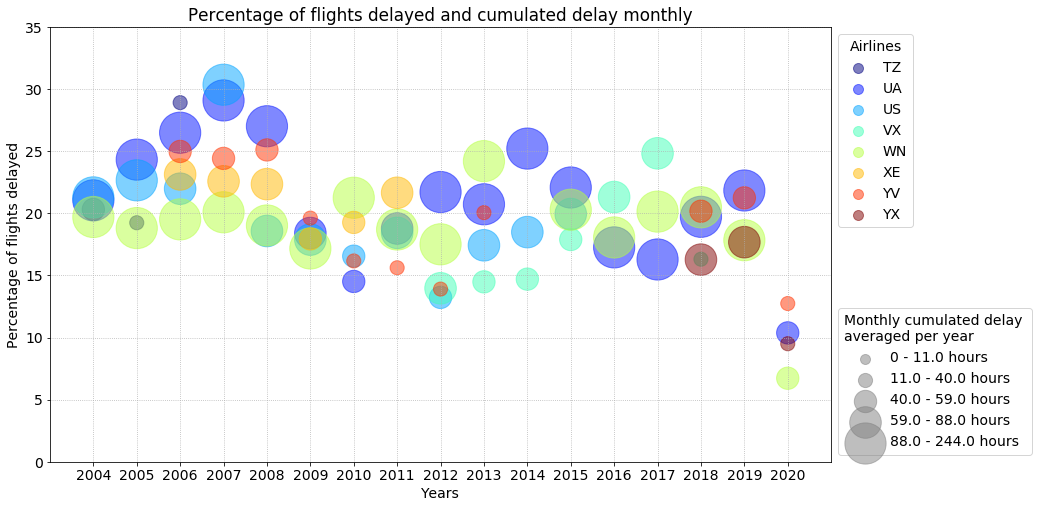

In [8]:
ds=df.groupby(['carrier','year'])[['arr_del_pct','arr_delay']].mean()#.sort_values(by='arr_del_pct')
ds['arr_del_pct_binned']=1+(pd.cut(ds['arr_del_pct'],range(0,50,10),labels=False))**3
_,bins=pd.qcut(ds.arr_delay,4,labels=False,retbins=1)
bins=[round(i) for i in bins]
bins.insert(0,0)
ds['arr_delay_binned']=1+(pd.cut(ds.arr_delay,bins,labels=False))**2
carriers=sorted(df.carrier.unique())

def plot_carriers(carriers):
    cmap=plt.cm.get_cmap('jet',len(carriers))#nipy_spectral,tab20,jet
    mult_s=100
    plt.figure(figsize=(14,8))
    for idx in range(len(carriers)):
        arl=carriers[idx]
        plt.scatter(ds.loc[(arl,)].index.values,ds.loc[(arl,),'arr_del_pct'].values,alpha=.5,color=cmap(idx),s=mult_s*ds.loc[(arl,),'arr_delay_binned'].values)
    plt.grid(linestyle=':')
    plt.xlim(2003,2021)
    plt.ylim(0,35)#ds.loc[(carriers,),'arr_delay'].max()+500
    plt.xticks(range(2004,2021))
    plt.xlabel('Years')
    plt.title('Percentage of flights delayed and cumulated delay monthly')
    plt.ylabel('Percentage of flights delayed')
    ax_leg_col=[plt.scatter(0,0,alpha=.5,color=cmap(idx),s=100) for idx in range(len(carriers))]
    ax_leg_size=[plt.scatter(0,0,alpha=.5,color='grey',s=mult_s*idx) for idx in sorted(ds.arr_delay_binned.unique())[:-1]]
    leg_col=plt.legend(ax_leg_col,carriers,bbox_to_anchor=(1,1.),title='Airlines',loc='upper left')
    plt.legend(ax_leg_size,[str(round(bins[i]/60))+' - '+str(round(bins[i+1]/60))+' hours' for i in range(len(bins)-1)],
               bbox_to_anchor=(1,0),loc='lower left',title='Monthly cumulated delay \naveraged per year')
    plt.gcf().add_artist(leg_col)
    plt.show()

plot_carriers(carriers[20:])

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!